# imports

In [91]:
import pandas
from pylab import *

from sklearn.model_selection import train_test_split

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# data acquisition

In [2]:
data_path = "customer_churn.csv"

In [12]:
df = pandas.read_csv(data_path, index_col=0)
# vérifier s'il y a des valeurs nulles
df = df.sample(frac=1) # mélanger les lignes aléatoirement
df = df.reset_index() # redéfinir l'index des lignes pour qu'il soit séquentiel 
df.head()

,index,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,2834,WV,139,area_code_415,no,no,0,271.6,130,46.17,...,131,13.26,136.3,108,6.13,11.6,9,3.13,2,no
1,2091,NC,106,area_code_415,no,yes,37,223.5,104,38.00,...,99,19.98,140.1,90,6.30,10.6,5,2.86,2,no
2,1235,IA,86,area_code_408,no,no,0,126.3,115,21.47,...,112,14.35,154.6,95,6.96,9.8,7,2.65,2,no
3,1825,KS,138,area_code_510,no,yes,26,183.9,83,31.26,...,93,20.46,185.7,125,8.36,15.0,3,4.05,1,no
4,3046,MN,57,area_code_415,no,no,0,272.7,74,46.36,...,85,19.12,178.2,104,8.02,10.5,3,2.84,2,yes


# data cleaning

In [4]:
# traiter les colonnes contenant des valeurs catégorielles
X_str = df.select_dtypes(include=object)
X_str = X_str.drop(["churn"], axis='columns')
X_str = pandas.get_dummies(X_str, drop_first=True)


In [5]:
# traiter les colonnes contenant des valeurs numérique

X_nonstr = df.select_dtypes(exclude=object)
X_nonstr = X_nonstr.drop(["index"], axis='columns')

In [6]:
X = pandas.merge(X_str, X_nonstr, left_index=True, right_index=True)

In [7]:
y = df["churn"]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)
print(y.value_counts(normalize=True)*100)
print(y_train.value_counts(normalize=True)*100)
print(y_test.value_counts(normalize=True)*100)

no     85.508551
yes    14.491449
Name: churn, dtype: float64
no     85.52138
yes    14.47862
Name: churn, dtype: float64
no     85.457271
yes    14.542729
Name: churn, dtype: float64


In [36]:
""" pour faire le split equilibré manuellement 
yes_mask = y == "yes"
no_mask = yes_mask.apply(lambda x : not x)
y_yes = y[yes_mask]
y_no = y[no_mask] 
X_yes = X[yes_mask]
X_no = X[no_mask] 
X_yes = X_yes.sample(frac=1)
shuffle_index = X_yes.index
y_yes = y_yes[shuffle_index]
"""

In [67]:
""" pour élimininer une des deux colonnes qui sont corrélées 
RF = RandomForestClassifier()
X_train_tmp = X_train.drop(["total_day_charge"], axis=1)
RF.fit(X_train_tmp, y_train)

feat_importance = pandas.DataFrame([(X_train_tmp.columns[i], RF.feature_importances_[i]*100) for i in range(len(RF.feature_importances_))],
                 columns=["feature_name", "feature_importance"])
                 
tmp = X_test["total_day_charge"] / X_test["total_day_minutes"]

"""

,feature_name,feature_importance
57,total_day_minutes,21.900297
68,number_customer_service_calls,10.591713
61,total_eve_charge,5.899154
52,international_plan_yes,5.565566
59,total_eve_minutes,5.133317


In [106]:
RF = RandomForestClassifier(max_depth=1000)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
print("accuracy : ", accuracy_score(y_test, y_pred))
print("precision : ", precision_score(y_test, y_pred, pos_label="yes"))
print("recall : ", recall_score(y_test, y_pred, pos_label="yes"))
print("f1_score : ", f1_score(y_test, y_pred, pos_label="yes"))      

accuracy :  0.9010494752623688
precision :  0.8297872340425532
recall :  0.4020618556701031
f1_score :  0.5416666666666666


In [102]:
feat_importance = pandas.DataFrame([(X_train.columns[i], RF.feature_importances_[i]*100) for i in range(len(RF.feature_importances_))],
                 columns=["feature_name", "feature_importance"])
feat_importance.sort_values(by="feature_importance", ascending=False).head()


,feature_name,feature_importance
59,total_day_charge,13.693609
57,total_day_minutes,11.674593
69,number_customer_service_calls,10.409721
60,total_eve_minutes,6.806779
52,international_plan_yes,5.690680


accuracy :  0.9085457271364318
precision :  0.86
recall :  0.44329896907216493
f1_score :  0.5850340136054422


In [120]:
def test_model(model_type, X_train, y_train, X_test, y_test, **kwargs):
    model = model_type(**kwargs)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {"accuracy" : accuracy_score(y_test, y_pred),
            "precision" : precision_score(y_test, y_pred, pos_label="yes"),
            "recall" : recall_score(y_test, y_pred, pos_label="yes"),
            "f1_score" : f1_score(y_test, y_pred, pos_label="yes")}    

In [132]:
res = {}
model_types = [RandomForestClassifier, DecisionTreeClassifier, 
               LogisticRegression, AdaBoostClassifier]
for model_type in model_types:
    res[model_type.__name__] = test_model(model_type, X_train, y_train, X_test, y_test)


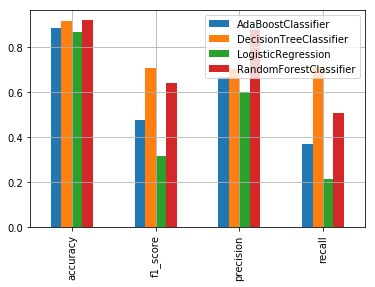

In [167]:
df_res = pandas.DataFrame(res)
df_res.plot(kind = "bar")
grid(which="both")
savefig("results/res.png")
df_res.to_excel("results/res.xlsx")

In [125]:
res = test_model(LogisticRegression, X_train, y_train, X_test, y_test)
res

{'accuracy': 0.8680659670164917,
 'f1_score': 0.3333333333333333,
 'precision': 0.6285714285714286,
 'recall': 0.2268041237113402}

In [127]:
res = test_model(AdaBoostClassifier, X_train, y_train, X_test, y_test)
res

{'accuracy': 0.881559220389805,
 'f1_score': 0.47682119205298024,
 'precision': 0.6666666666666666,
 'recall': 0.3711340206185567}

In [156]:
def fun(L=None):
    if L is None: 
        L={"a": 10}
    L["a"]*= 10
    print(L)

In [165]:
savefig